# File Creater for the TOLIMAN Pupil

Install necessary packages

In [19]:
import matplotlib.pyplot as plt
import jax.numpy as np

import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import src.OpticsSupport as OpticsSupport
import src.PlottingSupport as PlottingSupport
import src.STLMaker as STLMaker
import math

In [20]:
psf_flag = False
create_cutout = False
make_stl = False

## Parameters

In [21]:
# Aperture parameters
ratio = 1  # Ratio to scale the aperture by (e.g. 5 => 5-inch aperture becomes 1-inch aperture)
aperture_npix = 2000  # Number of pixels across the aperture
aperture_diameter = 0.125 / ratio  # Clear aperture diameter (m)
secondary_diameter = 0.032 / ratio  # Secondary mirror diameter (m)
spider_width = 0.002 / ratio  # Spider width (m)

# Observations wavelegths (bandpass of 530-640nm)
wavelengths = np.linspace(530e-9, 640e-9, 100)  # Wavelengths to simulate (m)

# Subtrate parameters
n1 = 1  # Refractive index of free space
n2 = 1.5424  # Refractive index of Zerodur

# Mask
mask_path = "diffractive_pupil.npy"
phase_mask = np.load(mask_path) * np.pi  # Load the mask and convert to phase

# Grating parameters
amplitude = 375e-9  # Amplitude of the grating (m). Peak to peak amplitude of the grating etched in the glass
det_npixels = 3600  # DO NOT TOUCH
pixel_scale = dlu.arcsec2rad(0.375) * ratio  # 0.375 arcsec per pixel
max_reach = 0.691443  # Max wavelength to diffract to 80% of the diagonal length of the detector

## Create the mask

In [22]:
# Make the mask
mask, raw_mask, X, Y = OpticsSupport.HelperFunctions.make_grating_mask(
    phase_mask,
    aperture_npix,
    aperture_diameter,
    secondary_diameter,
    spider_width,
    wavelengths,
    amplitude,
    det_npixels,
    pixel_scale,
    max_reach,
    n1,
    n2,
    out=0.0,
    apply_spiders=False,
    return_raw=True,
)

Grating amplitude: 3.157899856567383
Nyquist Ratio: 1.5789499282836914
Grating period: 0.0001973687467398122m


Plot mask to check correct pattern and resolution

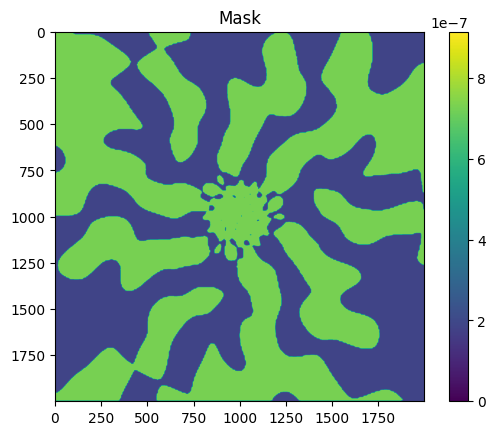

In [23]:
PlottingSupport.Plotting.printColormap(
    mask, title="Mask", colorbar=True, colormap="viridis"
)

Create the phase mask and the instrument

In [24]:
wf_npixels = aperture_npix  # Number of pixels across the wavefront
peak_wavelength = np.mean(wavelengths)  # Peak wavelength of the bandpass (m)

# Create Telescope
phase_mask = OpticsSupport.HelperFunctions.createPhaseMask(
    raw_mask, peak_wavelength, n1, n2
)  # Create the phase mask
mask = dl.Optic(phase=phase_mask)
optics = dlT.TolimanOpticalSystem(
    wf_npixels=wf_npixels, mask=mask, psf_npixels=det_npixels, oversample=1
)
source = dlT.AlphaCen(n_wavels=20, separation=8, position_angle=30)
instrument = OpticsSupport.HelperFunctions.createTolimanTelescope(
    optics, source, ratio
)

In [25]:
optics

TolimanOpticalSystem(
  wf_npixels=2000,
  diameter=0.125,
  layers={
    'aperture':
    TransmissiveLayer(transmission=f32[2000,2000], normalise=True),
    'pupil':
    Optic(opd=None, phase=f32[2000,2000], transmission=None, normalise=False)
  },
  psf_npixels=3648,
  oversample=1,
  psf_pixel_scale=0.375
)

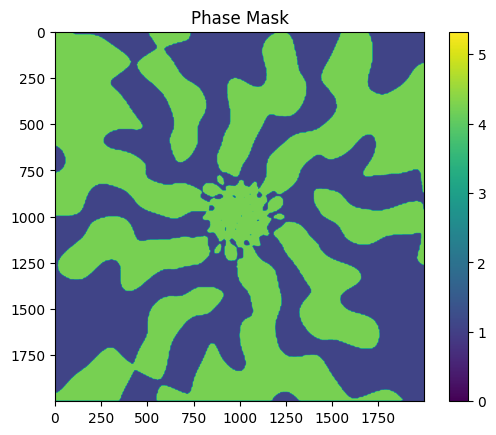

In [26]:
PlottingSupport.Plotting.printColormap(
    phase_mask, title="Phase Mask", colorbar=True, colormap="viridis"
)

Simulate the PSF

In [27]:
# Create PSF
if psf_flag:
    psf = instrument.model()

Display the PSF

In [28]:
if psf_flag:
    r = psf.shape[0]
    c = r // 2
    s = 64
    print(r // 10)

    central_psf = psf[c - s : c + s, c - s : c + s]
    sidelobe_psf = psf[
        math.floor(r / 7.5) : math.floor(r / 7.5) + r // 10,
        math.floor(r / 7.5) : math.floor(r / 7.5) + r // 10,
    ]
    PlottingSupport.Plotting.printColormap(
        psf**0.2, title="PSF", colorbar=True
    )
    plt.imsave("psf_full.png", psf**0.2, cmap="inferno")
    plt.imsave("central_psf.png", central_psf, cmap="inferno")
    plt.imsave("sidelobe_psf.png", sidelobe_psf, cmap="inferno")
    PlottingSupport.Plotting.printColormap(
        central_psf, title="PSF Central", colorbar=True
    )
    print(f"Central Flux: {(np.sum(central_psf)/np.sum(psf))*100:.2f}%")
    PlottingSupport.Plotting.printColormap(
        sidelobe_psf, title="PSF Sidelobe", colorbar=True
    )
    print(f"Sidelobe Flux: {(np.sum(sidelobe_psf)/np.sum(psf))*4*100:.2f}%")

### Elevating the phase mask

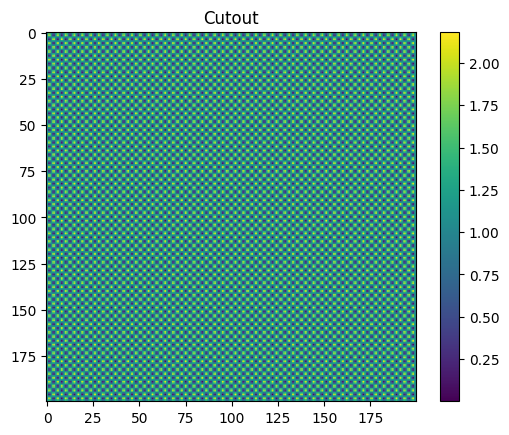

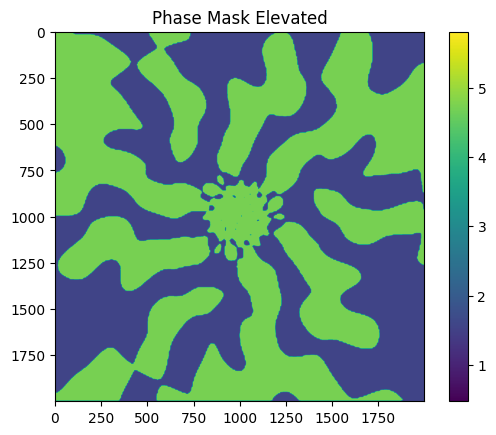

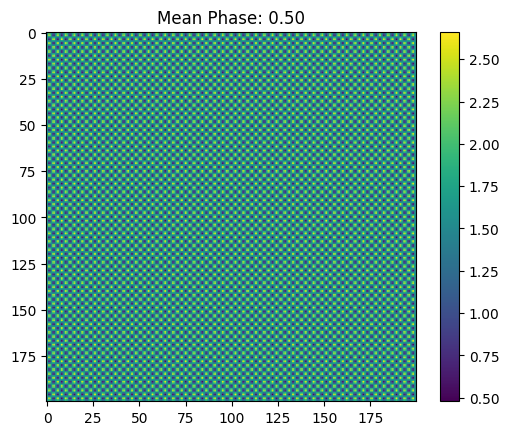

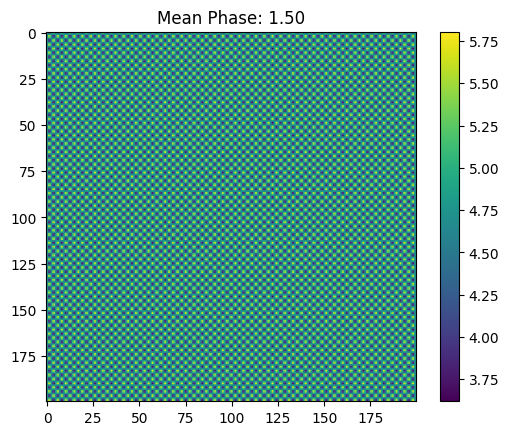

In [29]:
# Defining cutout areas
x_min = int((0 / 5) * aperture_npix)
x_max = int((0.5 / 5) * aperture_npix)
y_low_min = int((3.6 / 5) * aperture_npix)
y_low_max = int((4.1 / 5) * aperture_npix)
y_high_min = int((0.5 / 5) * aperture_npix)
y_high_max = int((1 / 5) * aperture_npix)

# Cutout a lower section and elevate so the average is at 0.5π and 1.5π for the two steps
cutout = phase_mask[y_low_min:y_low_max, x_min:x_max]
PlottingSupport.Plotting.printColormap(
    cutout, title="Cutout", colorbar=True, colormap="viridis"
)
cutout_mean = np.mean(cutout)
elevation = 0.5 * np.pi - cutout_mean
phase_mask_elevated = phase_mask + elevation
PlottingSupport.Plotting.printColormap(
    phase_mask_elevated,
    title="Phase Mask Elevated",
    colorbar=True,
    colormap="viridis",
)

# Check lower section
low_cutout_elevated = phase_mask_elevated[y_low_min:y_low_max, x_min:x_max]
cutout_low_mean_phase = np.mean(low_cutout_elevated) / np.pi
PlottingSupport.Plotting.printColormap(
    low_cutout_elevated,
    title=f"Mean Phase: {cutout_low_mean_phase:.2f}",
    colorbar=True,
    colormap="viridis",
)

if not math.isclose(0.5, cutout_low_mean_phase, rel_tol=1e-2):
    raise Exception(f"Low cutout not at 0.5: {cutout_low_mean_phase:.5f}")

# Check higher section
high_cutout_elevated = phase_mask_elevated[y_high_min:y_high_max, x_min:x_max]
cutout_high_mean_phase = np.mean(high_cutout_elevated) / np.pi
PlottingSupport.Plotting.printColormap(
    high_cutout_elevated,
    title=f"Mean Phase: {cutout_high_mean_phase:.2f}",
    colorbar=True,
    colormap="viridis",
)

if not math.isclose(1.5, cutout_high_mean_phase, rel_tol=1e-2):
    raise Exception(f"High cutout not at 1.5: {cutout_high_mean_phase:.5f}")

In [30]:
p2p = (low_cutout_elevated.max() - low_cutout_elevated.min()) / (2 * np.pi)
print(f"Single sinusoid p2p: {p2p: .3f}\u03C0")

Single sinusoid p2p:  0.348π


Make a circular cutout

In [31]:
scale = 0.2
x_centre = int((4 / 5) * aperture_npix)
y_centre = int((2.6 / 5) * aperture_npix)
circle_cutout_region = (
    int((4 / 5) * aperture_npix),
    int((2.6 / 5) * aperture_npix),
)

if create_cutout:
    inch_cutout = OpticsSupport.HelperFunctions.createCircularCutout(
        scale, circle_cutout_region, aperture_npix
    )

    inch_cutout_elevated_phase_mask = (phase_mask + elevation) * inch_cutout
    PlottingSupport.Plotting.printColormap(
        inch_cutout_elevated_phase_mask,
        title="Inch Cutout Mask",
        colorbar=True,
        colormap="viridis",
    )

    radius = int(aperture_npix * 0.2 / 2)
    zoom = inch_cutout_elevated_phase_mask[
        (y_centre - radius) : (y_centre + radius),
        (x_centre - radius) : (x_centre + radius),
    ]
    PlottingSupport.Plotting.printColormap(
        zoom, title="Inch Cutout Zoom", colorbar=True, colormap="viridis"
    )

    plt.imsave("Generated Files/Images/inch_cutout.png", zoom)
    np.save("Generated Files/Engineering/inch_cutout.npy", zoom)

Cutout the shape of the telescope

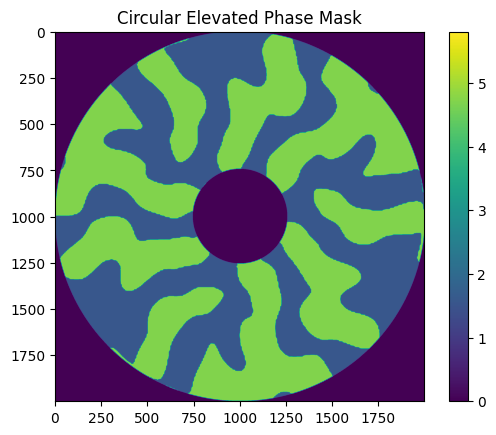

In [32]:
circular_mask_outer = OpticsSupport.HelperFunctions.createCircularMask(
    aperture_npix, aperture_npix, radius=aperture_npix / 2
)
inner_r = (aperture_npix * (secondary_diameter / aperture_diameter)) / 2
circular_mask_inner = 1 - OpticsSupport.HelperFunctions.createCircularMask(
    aperture_npix, aperture_npix, radius=inner_r
)
circular_mask = circular_mask_outer & circular_mask_inner

circular_elevated_phase_mask = (phase_mask + elevation) * circular_mask
PlottingSupport.Plotting.printColormap(
    circular_elevated_phase_mask,
    title="Circular Elevated Phase Mask",
    colorbar=True,
    colormap="viridis",
)

Convert the mask to a bitmap (adding to make mean pi)

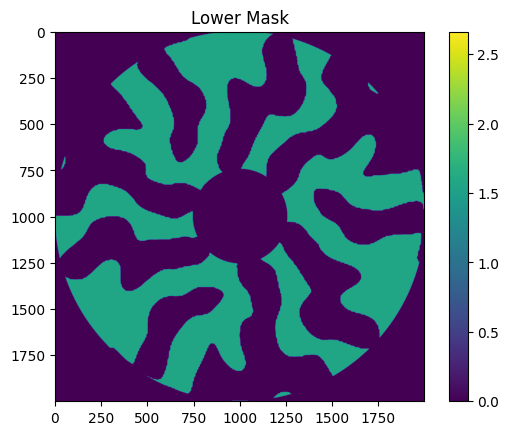

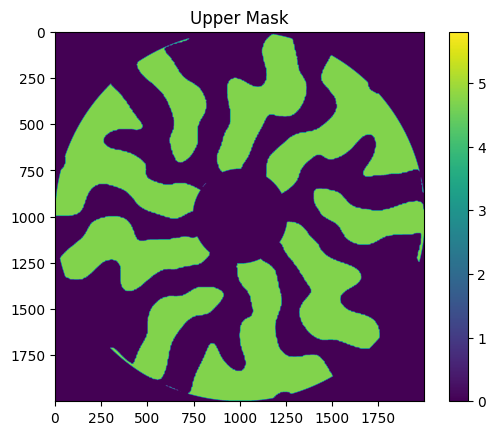

In [33]:
modified_mask_lower = circular_elevated_phase_mask.at[
    np.where(circular_elevated_phase_mask > 3)
].set(0)

modified_mask_upper = circular_elevated_phase_mask.at[
    np.where(circular_elevated_phase_mask < 3)
].set(0)


PlottingSupport.Plotting.printColormap(
    modified_mask_lower,
    title="Lower Mask",
    colorbar=True,
    colormap="viridis",
)

PlottingSupport.Plotting.printColormap(
    modified_mask_upper,
    title="Upper Mask",
    colorbar=True,
    colormap="viridis",
)

In [34]:
np.save(
    "Generated Files/Engineering/modified_mask_lower.npy",
    modified_mask_lower,
)
plt.imsave(
    "Generated Files/Images/modified_mask_lower.png",
    modified_mask_lower,
)

np.save(
    "Generated Files/Engineering/modified_mask_upper.npy",
    modified_mask_upper,
)
plt.imsave(
    "Generated Files/Images/modified_mask_upper.png",
    modified_mask_upper,
)

# np.save(
#     "modified_mask_lower.npy",
#     modified_mask_lower,
# )
# plt.imsave(
#     "modified_mask_lower.png",
#     modified_mask_lower,
# )

# np.save(
#     "modified_mask_upper.npy",
#     modified_mask_upper,
# )
# plt.imsave(
#     "modified_mask_upper.png",
#     modified_mask_upper,
# )

In [35]:
np.save(
    "Generated Files/Engineering/new_diffractive_pupil.npy",
    circular_elevated_phase_mask,
)
plt.imsave(
    "Generated Files/Images/new_diffractive_pupil.png",
    circular_elevated_phase_mask,
)

In [36]:
if make_stl == True:
    mask = circular_elevated_phase_mask
    STLMaker.Mesh2STL.mesh_to_stl(
        X,
        Y,
        mask,
        aperture_npix,
        "Generated Files/Engineering/test_file_m",
        unit_in="m",
        unit_out="m",
        binary=True,
    )
    STLMaker.Mesh2STL.mesh_to_stl(
        X,
        Y,
        mask,
        aperture_npix,
        "Generated Files/Engineering/test_file_mm",
        unit_in="m",
        unit_out="mm",
        binary=True,
    )
    STLMaker.Mesh2STL.mesh_to_stl(
        X,
        Y,
        mask,
        aperture_npix,
        "Generated Files/Engineering/test_file_um",
        unit_in="m",
        unit_out="um",
        binary=True,
    )
    STLMaker.Mesh2STL.mesh_to_stl(
        X,
        Y,
        mask,
        aperture_npix,
        "Generated Files/Engineering/test_file_nm",
        unit_in="m",
        unit_out="nm",
        binary=True,
    )